Check running TensorFlow version

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

# News classification

This is a single-label multiclass classification problem (46 classes). 

The dataset I will use is [Reuters Newswires](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection), it contains a set of 8,982 highly polar movie reviews for training, and 2,246 for testing.

I will use a basic dense model to start with and find out how well it performs on this dataset. 1D conv, LSTM, GRU, Bidirectional are stuff I can try later.

In [2]:
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

import random as rand

import numpy as np

## Load Reuters Newswires and get familiar with it

In [6]:
vocab_size = 10000
(train_x, train_y), (test_x, test_y) = datasets.reuters.load_data(num_words=vocab_size)

2113536/2110848 [==============================] - 1s 1us/step


In [7]:
train_x.shape, train_y.shape

((8982,), (8982,))

In [8]:
test_x.shape, test_y.shape

((2246,), (2246,))

Load the word index dictionary and reverse a few triaing strings

Note: the indices are offset by 3 because 0, 1, and 2 are reserved indices for "padding", "start of sequence", and "unknown".

In [9]:
word_index = datasets.imdb.get_word_index()
word_index_reversed = {v: k for k, v in word_index.items()}

In [10]:
translate_sentence = lambda sentence : " ".join([word_index_reversed.get(word - 3, '?') for word in sentence])

In [11]:
random_indecies = rand.choices(list(range(train_x.shape[0])), k=2)

for index in random_indecies:
    sentence = translate_sentence(train_x[index][1:])
    print(sentence, end="\n\n")

more special are this son are from structure lion this obnoxious daily first has block nephew this has inventive tank show through from feel enjoy worker out but singing and fails rainy perhaps disappointed on jaw ridiculous is partners do as it

such reporter do to although have you later funny actress br their i real continuity will under the under at be act don't indian and whatever club was to well college at be space was doesn't the usa some to was ago like maybe criminals for every get coming is you're is wind indian and the continuity under at no with carmen for get you're as it



## Check how balanced the data is

In [27]:
from collections import Counter

labels_counter = Counter(list(map(int, train_y)))
labels_counter = {k: v for k, v in labels_counter.items()}
min(labels_counter.values()), max(labels_counter.values())

(10, 3159)

## Pad the training and test data

Because of input data is of different sizes, I will set a max length limit on them or pad them if their length was shorter than max length

In [28]:
max_length = 200

# Default :: , padding='pre', truncating='pre'
train_x = pad_sequences(train_x, maxlen=max_length)
test_x = pad_sequences(test_x, maxlen=max_length)

In [29]:
train_x.shape, test_x.shape

((8982, 200), (2246, 200))

## Encode y as one hot encoding

In [32]:
number_of_classes = len(np.unique(train_y))
number_of_classes

46

In [33]:
train_y = to_categorical(train_y, number_of_classes)
test_y = to_categorical(test_y, number_of_classes)

In [34]:
train_y.shape, train_y[0]

((8982, 46),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

## Train

In [55]:
model = Sequential()
model.add(layers.Embedding(vocab_size, 1024, input_length=max_length))  # By increasing the number of outputs, the accuracy can be improved quickly.
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 1024)         10240000  
_________________________________________________________________
global_average_pooling1d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 46)                2990      
Total params: 10,382,446
Trainable params: 10,382,446
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
history = model.fit(x=train_x, y=train_y, validation_split=0.2, shuffle=True, batch_size=512, epochs=20)
history.history.keys()

Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 7s 1ms/sample - loss: 3.1658 - accuracy: 0.2283 - val_loss: 2.4081 - val_accuracy: 0.3695
Epoch 2/20
7185/7185 [==============================] - 7s 970us/sample - loss: 2.2699 - accuracy: 0.3922 - val_loss: 2.1435 - val_accuracy: 0.4519
Epoch 3/20
7185/7185 [==============================] - 7s 983us/sample - loss: 2.0486 - accuracy: 0.4479 - val_loss: 2.0748 - val_accuracy: 0.5058
Epoch 4/20
7185/7185 [==============================] - 7s 1ms/sample - loss: 1.8980 - accuracy: 0.5066 - val_loss: 1.9278 - val_accuracy: 0.4290
Epoch 5/20
7185/7185 [==============================] - 7s 985us/sample - loss: 1.7512 - accuracy: 0.5390 - val_loss: 1.7275 - val_accuracy: 0.5615
Epoch 6/20
7185/7185 [==============================] - 7s 995us/sample - loss: 1.6221 - accuracy: 0.5825 - val_loss: 1.6206 - val_accuracy: 0.5771
Epoch 7/20
7185/7185 [==============================] - 7s 992us/sam

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

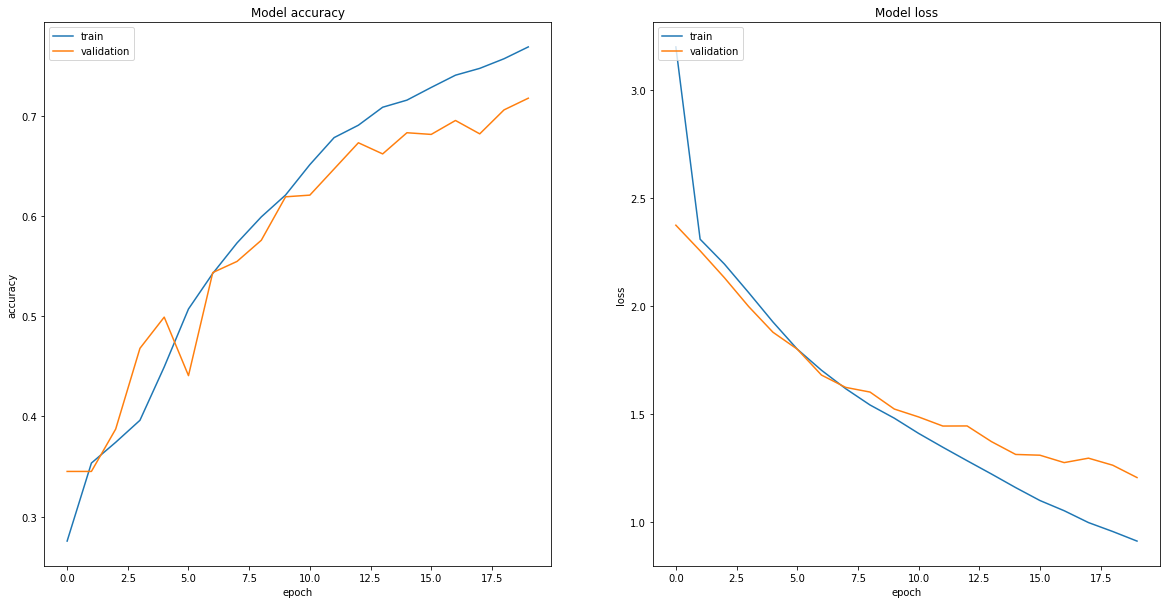

In [48]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Evaluate

In [49]:
loss, accuracy = model.evaluate(x=test_x, y=test_y)
loss, accuracy

2246/2246 [==============================] - 0s 67us/sample - loss: 1.2948 - accuracy: 0.6968


(1.2947593859445805, 0.6967943)

## Predict on one sentence

In [59]:
model.trainable = False

# Compile model so changes to trainable would take effect
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
sentence

"such reporter do to although have you later funny actress br their i real continuity will under the under at be act don't indian and whatever club was to well college at be space was doesn't the usa some to was ago like maybe criminals for every get coming is you're is wind indian and the continuity under at no with carmen for get you're as it"

In [51]:
index = 0

sentence = test_x[index]
translate_sentence(sentence), test_y[index]

("? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? the chris connection is knew catchy many to you character he melodramatic in now am low at be be expectations second a ? before is spent hollywood i ? were is ? were little the there's bad action br is fake to the set and ? of animation if is ? of i've likable incredibly whilst among make here father of the guys them place think actor you from poor film dramatic almost drags usual she movie a love my in that time told are br see of the needs them just because second entertainment it movie a with within an that br is fake deal your die but the canadian am low what was plays mother was soon the too he and the low sense if br is fake on usual has movie shot his up ? ? and fact enjoyed as it",
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.,

In [52]:
sentence = sentence.reshape(1, *sentence.shape)
sentence.shape

(1, 200)

In [54]:
output = model(sentence)
np.argmax(output)

3